### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@dev`

This projects contains the code for the Monitor 1.0 pipeline as well as Monitor's built-in anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [1]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor,)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster, KDEAnomalyScore, VIAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

### Setting up a database object

We connect to the 'real' tenant's database to update the model store.
While not use for demo purposes it allows to directly save the model after training for the pipeline to pick it up.

In [2]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2021-11-29T22:25:45.014 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
2021-11-29T22:25:45.016 WARNING iotfunctions.db.__init__ Unable to locate CORE API URL.. using base API URL
2021-11-29T22:25:58.005 INFO iotfunctions.db.__init__ Data Dictionary is not available.


### Loading and minimally cleansing pump data

The CSV file contains sensor readings for two pumps with ids '04714B6046D5' and '04714B604101'.
This data is already 'unrolled', i.e. json arrays turned into singular events, and normalized 

In [93]:
# load data
df_input = pd.read_csv('./data/AllOfArmstark.csv', parse_dates=['timestamp'], comment='#')
df_input = df_input.sort_values(by='timestamp').set_index('timestamp')

# simple data cleansing
df_input.dropna(inplace=True)

# set multi-index in a similar way as the Monitor 1.0 pipeline
df_input = df_input.reset_index().set_index(['entity','timestamp'])

In [4]:
# make it plottable
sz = 500
df_input['max'] = sp.ndimage.maximum_filter1d(df_input['Vx'], size=sz)

#### Plotting data

Vibration and Impeller speed

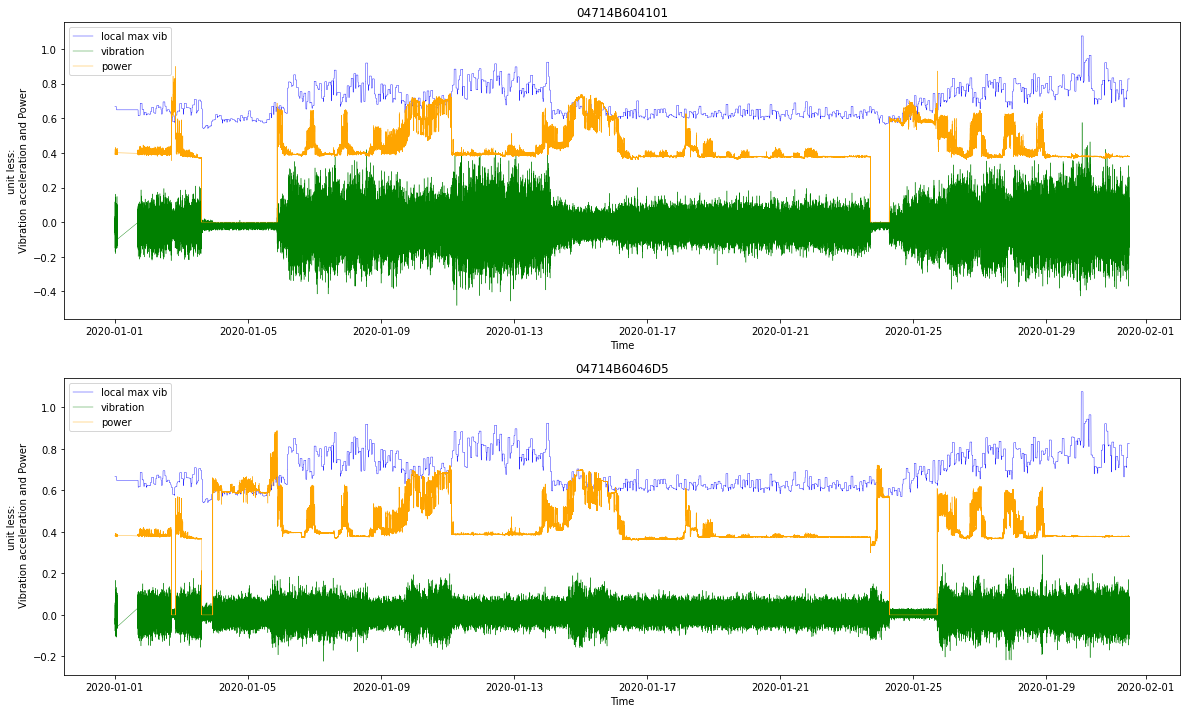

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12), squeeze=False)
i = 0
for tag in df_input.index.levels[0]:
    ax[i,0].plot(df_input.loc[tag]['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
    ax[i,0].plot(df_input.loc[tag]['Vx'], lw=0.4, color='green', label='vibration')
    ax[i,0].plot(df_input.loc[tag]['Ap']/6, lw=0.4, color='orange', label='power')
    ax[i,0].legend()
    ax[i,0].set_title(tag)
    ax[i,0].set_xlabel('Time')
    ax[i,0].set_ylabel('unit less:\n Vibration acceleration and Power')
    i+=1


#### Why customers are interested in vibration ?

Vibration is an undesired side effect of pump operation in general.
Vibration causes tear and wear of moving parts, from grinding down ball-bearings to loosing tie-down bolts etc.
Vice versa wear and tear causes increase in severity.
So essentially we want to monitor vibration and get alerted if the vibration levels changes significantly. 

#### Why we need instance specific models ?

Resonance is a condition where the forced vibration frequency aligns with a structural or rotor natural frequency resulting in amplified vibration.

#### Could we predict vibration of (rotor) speed ?

We have tried.

#### What did we do instead ?

Because of resonance effects we expected to see vibration patterns depending on impeller speed. Since we're only interested in outliers we look for low density areas of vibration w.r.t speed.
We applied bivariate kernel density estimates, found out that this is quite CPU intensive and looked for a more light-weight approximation

In [91]:
# just in case ...
df_i = df_input.copy()

### Training a small VAE

Try to approximate the density of vibration as Gaussian w.r.t. speed

We spend 2 layers for mean, 3 layers for sigma in the custom Monitor function VIAnomalyScore.

In [7]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

viai = VIAnomalyScore(['Ap'], ['Vx'])

#viai.delete_model = True  # make sure old models are deleted
viai.auto_train = True  # enforce training
viai.epochs = 80        # suffices

et = viai._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
viai._entity_type = et
df_i = viai.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()

2021-11-29T22:25:59.772 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-11-29T22:25:59.774 DEBUG root.__init__ __init__VIAnomalyScore
2021-11-29T22:25:59.774 DEBUG root.__init__ __init__ done with parameters: Ap.Vx
2021-11-29T22:25:59.775 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.7.0
2021-11-29T22:25:59.775 DEBUG iotfunctions.util.__init__ Starting trace
2021-11-29T22:25:59.776 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20211129212559
2021-11-29T22:25:59.776 DEBUG iotfunctions.util.__init__ auto_save None
2021-11-29T22:25:59.777 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-11-29T22:25:59.777 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2021-11-29T22:25:59.777 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_VIANOMALYSCORE
Fu

,Vx,Vy,Vz,Ap,As,speed,max,predicted_Vx,pred_dev_Vx
count,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000
mean,-0.006552,-0.027379,-0.959099,2.430800,0.971285,0.971500,0.197303,-0.006929,0.216758
std,0.061913,0.037608,0.073353,0.903795,0.288768,0.288164,0.087697,0.014953,0.070419
min,-0.481400,-0.359400,-1.415000,0.000000,0.000000,0.000000,0.040000,-0.037002,0.067248
25%,-0.034200,-0.044900,-0.999000,2.260200,1.032000,1.031744,0.125000,-0.022233,0.162484
50%,-0.003900,-0.027300,-0.960000,2.330400,1.037000,1.037000,0.171900,0.004483,0.192151
75%,0.027300,-0.009800,-0.922900,2.677800,1.057000,1.057954,0.266600,0.008096,0.289816
max,0.575200,0.286100,-0.474600,5.401600,1.201000,1.195605,0.575200,0.012400,0.304859


### Distribution of vibration (x-axis) w.r.t pump speed


Text(0.5, 1.0, 'bad pump')

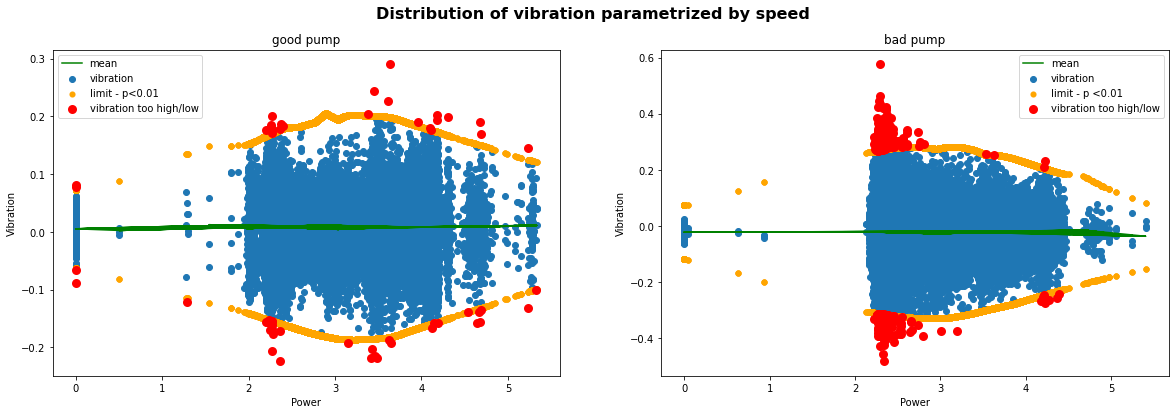

In [8]:
#
# Vibration outside of the area marked by the orange line is an outlier
#

df_1 = df_i.loc['04714B6046D5'].copy()
df_2 = df_i.loc['04714B604101'].copy()

arr1 = np.where(df_1['Vx'] > df_1['predicted_Vx'] + df_1['pred_dev_Vx'], df_1['Vx'], 0) + \
       np.where(df_1['Vx'] < df_1['predicted_Vx'] - df_1['pred_dev_Vx'], df_1['Vx'], 0)
arr1[arr1 == 0] = np.nan
df_1['Anomaly'] = arr1
arr2 = np.where(df_2['Vx'] > df_2['predicted_Vx'] + df_2['pred_dev_Vx'], df_2['Vx'], 0) + \
       np.where(df_2['Vx'] < df_2['predicted_Vx'] - df_2['pred_dev_Vx'], df_2['Vx'], 0)
arr2[arr2 == 0] = np.nan
df_2['Anomaly'] = arr2
#df_1[df_1['Anomaly'] == 0] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

fig.suptitle("Distribution of vibration parametrized by speed", fontsize=16, fontweight='bold')

ax[0,0].scatter(df_1['Ap'], df_1['Vx'], label='vibration')
ax[0,0].plot(df_1['Ap'], df_1['predicted_Vx'], color='green', label='mean')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] - df_1['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p<0.01')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] + df_1['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['Ap'], df_1['Anomaly'], color='red', lw=3, label='vibration too high/low')
ax[0,0].set_xlabel('Power')
ax[0,0].set_ylabel('Vibration')
ax[0,0].legend()
ax[0,0].set_title('good pump')

ax[0,1].scatter(df_2['Ap'], df_2['Vx'],  label='vibration')
ax[0,1].plot(df_2['Ap'], df_2['predicted_Vx'], color='green', label='mean')
ax[0,1].scatter(df_2['Ap'], df_2['predicted_Vx'] - df_2['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p <0.01')
ax[0,1].scatter(df_2['Ap'], df_2['predicted_Vx'] + df_2['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,1].scatter(df_2['Ap'], df_2['Anomaly'], color='red', lw=3, label='vibration too high/low')
ax[0,1].set_xlabel('Power')
ax[0,1].set_ylabel('Vibration')
ax[0,1].legend()
ax[0,1].set_title('bad pump')


#plt.fill_between(df_1['Ap'], - df_1['pred_dev_Vx'], df_1['pred_dev_Vx'], alpha=0.2)

In [9]:
# plotting aid
sz = 500
df_1['max'] = sp.ndimage.maximum_filter1d(df_1['Vx'], size=sz)
df_2['max'] = sp.ndimage.maximum_filter1d(df_2['Vx'], size=sz)

Text(0.5, 1.0, 'bad pump')

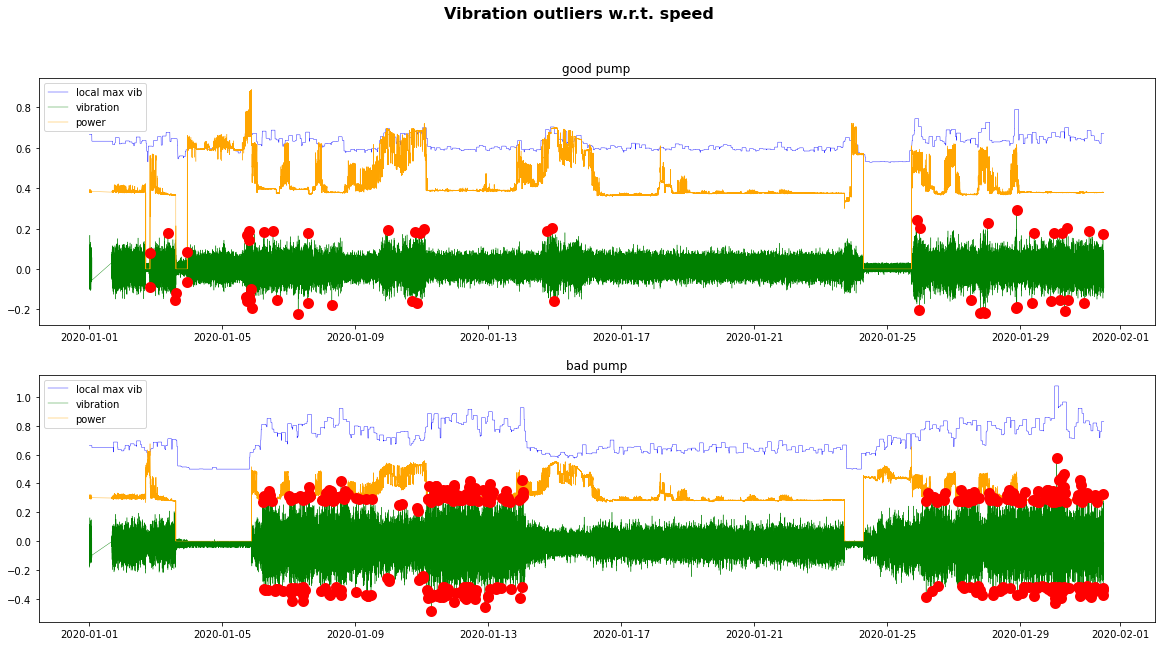

In [10]:
# Outliers are f
fig, ax = plt.subplots(2, 1, figsize=(20, 10), squeeze=False)

fig.suptitle("Vibration outliers w.r.t. speed", fontsize=16, fontweight='bold')

ax[0,0].plot(df_1['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
ax[0,0].plot(df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].plot(df_1['Ap']/6, lw=0.4, color='orange', label='power')
ax[0,0].scatter(df_1.index, df_1['Anomaly'], lw=5, color='red', zorder=10)
ax[0,0].legend()
ax[0,0].set_title('good pump')

ax[1,0].plot(df_2['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
ax[1,0].plot(df_2['Vx'], lw=0.4, color='green', label='vibration')
ax[1,0].plot(df_2['Ap']/8, lw=0.4, color='orange', label='power')
ax[1,0].scatter(df_2.index, df_2['Anomaly'], lw=5, color='red', zorder=10)
ax[1,0].legend()
ax[1,0].set_title('bad pump')


In [11]:
viai.active_models['04714B6046D5']

VI(
  (q_mu): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
  (q_log_var): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=35, bias=True)
    (3): ReLU()
    (4): Linear(in_features=35, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

#### What did the customer do with it ?

After we shared the idea, customer applied an even simpler rule-of-thumb:

Start with the data from the first 50 hours of operation, multiply the max with 1.5 and use that as a threshold. While much less 'fine-grained' it turned out to be good enough for them.

### Digression

Original approach with kernel density estimates - too CPU intensive to evaluate

Kept here for history

In [12]:
#df_i = df_input #.head(10000)

In [13]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

kdei = KDEAnomalyScore(0.000001, ['Ap'], ['Vx'], ['Vx_pred'])

kdei.delete_model = False

et = kdei._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
kdei._entity_type = et
df_i = kdei.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()


2021-11-29T22:26:12.568 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-11-29T22:26:12.569 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2021-11-29T22:26:12.569 DEBUG root.__init__ __init__KDEAnomalyScore
2021-11-29T22:26:12.570 DEBUG root.__init__ __init__ done with parameters: Ap.Vx
2021-11-29T22:26:12.570 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.7.0
2021-11-29T22:26:12.571 DEBUG iotfunctions.util.__init__ Starting trace
2021-11-29T22:26:12.572 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KDEAnomalyScore_20211129212612
2021-11-29T22:26:12.572 DEBUG iotfunctions.util.__init__ auto_save None
2021-11-29T22:26:12.572 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-11-29T22:26:12.573 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2021-11-29T22:26:12.573 DEBUG iotfunctions.metadata.__i

,Vx,Vy,Vz,Ap,As,speed,max,predicted_Vx,pred_dev_Vx,Vx_pred
count,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000
mean,-0.006552,-0.027379,-0.959099,2.430800,0.971285,0.971500,0.197303,-0.006929,0.216758,6.495236
std,0.061913,0.037608,0.073353,0.903795,0.288768,0.288164,0.087697,0.014953,0.070419,5.791464
min,-0.481400,-0.359400,-1.415000,0.000000,0.000000,0.000000,0.040000,-0.037002,0.067248,0.000763
25%,-0.034200,-0.044900,-0.999000,2.260200,1.032000,1.031744,0.125000,-0.022233,0.162484,1.504307
50%,-0.003900,-0.027300,-0.960000,2.330400,1.037000,1.037000,0.171900,0.004483,0.192151,5.307245
75%,0.027300,-0.009800,-0.922900,2.677800,1.057000,1.057954,0.266600,0.008096,0.289816,8.327839
max,0.575200,0.286100,-0.474600,5.401600,1.201000,1.195605,0.575200,0.012400,0.304859,20.305642


In [14]:
kdei.active_models['04714B6046D5']

KDE instance
Number of variables: k_vars = 2
Number of samples:   nobs = 129300
Variable types:      cc
BW selection method: normal_reference

In [98]:
import scipy as sp
sz = 500

df_i = df_i.reset_index().set_index('timestamp')

df_1 = df_i[df_i['entity'] == '04714B6046D5']
df_2 = df_i[df_i['entity'] == '04714B604101']
df_1['max'] = sp.ndimage.maximum_filter1d(df_1['Vx'], size=sz)
df_2['max'] = sp.ndimage.maximum_filter1d(df_2['Vx'], size=sz)


<ipython-input-98-2d24c19b8b7f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['max'] = sp.ndimage.maximum_filter1d(df_1['Vx'], size=sz)
<ipython-input-98-2d24c19b8b7f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['max'] = sp.ndimage.maximum_filter1d(df_2['Vx'], size=sz)


In [16]:
np.min(df_2['Vx_pred'])

0.000763395206525316

In [17]:
df_1['red'] = np.where(df_1['Vx_pred'].values < 0.01, 1, np.nan)
df_2['red'] = np.where(df_2['Vx_pred'].values < 0.01, 1, np.nan)

<ipython-input-17-957967957010>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['red'] = np.where(df_1['Vx_pred'].values < 0.01, 1, np.nan)
<ipython-input-17-957967957010>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['red'] = np.where(df_2['Vx_pred'].values < 0.01, 1, np.nan)


Text(0.5, 1.0, 'bad pump')

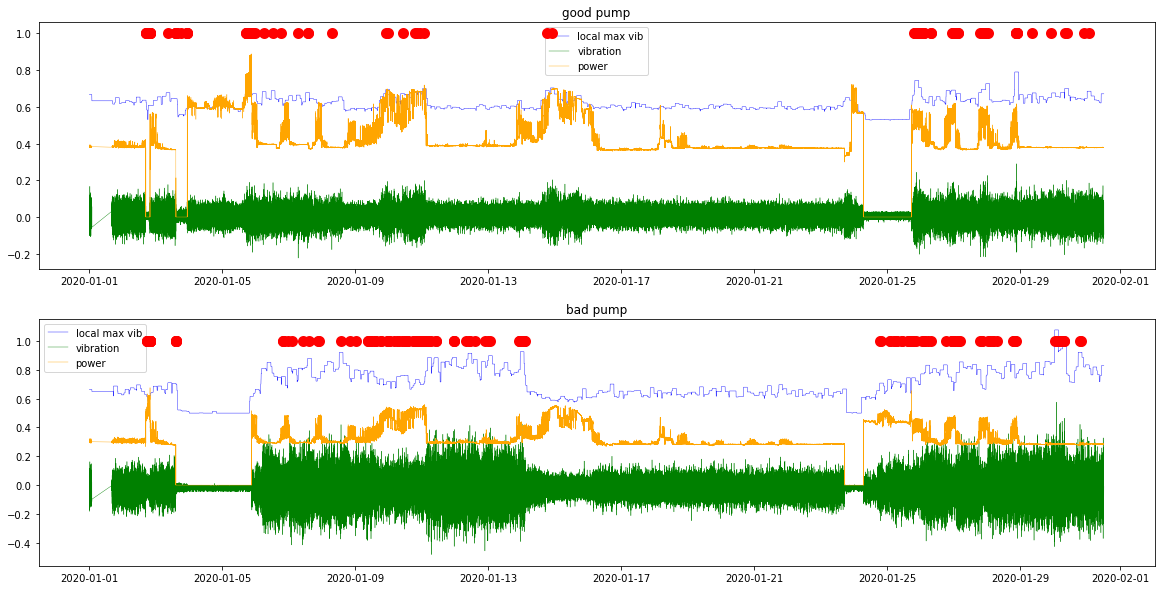

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), squeeze=False)
ax[0,0].plot(df_1['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
ax[0,0].plot(df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].plot(df_1['Ap']/6, lw=0.4, color='orange', label='power')
ax[0,0].scatter(df_1.index, df_1['red'], lw=5, color='red', zorder=10)
ax[0,0].legend()
ax[0,0].set_title('good pump')

ax[1,0].plot(df_2['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
ax[1,0].plot(df_2['Vx'], lw=0.4, color='green', label='vibration')
ax[1,0].plot(df_2['Ap']/8, lw=0.4, color='orange', label='power')
ax[1,0].scatter(df_2.index, df_2['red'], lw=5, color='red', zorder=10)
ax[1,0].legend()
ax[1,0].set_title('bad pump')


Vx      Vy      Vz      Ap     As  \
entity       timestamp                                                        
04714B604101 2020-01-01 00:02:12.713 -0.0625 -0.0908 -1.0332  2.3650  1.036   
04714B6046D5 2020-01-01 00:02:25.928 -0.0439 -0.0137 -1.0029  2.2904  1.036   
04714B604101 2020-01-01 00:03:12.713  0.0361  0.0078 -0.9141  2.3650  1.036   
04714B6046D5 2020-01-01 00:03:25.928 -0.0430 -0.0205 -0.9023  2.2904  1.036   
04714B604101 2020-01-01 00:04:12.713  0.1172 -0.0332 -0.9756  2.3650  1.036   
...                                      ...     ...     ...     ...    ...   
             2020-01-31 12:10:16.047 -0.0088 -0.0361 -0.9160  2.2800  1.032   
04714B6046D5 2020-01-31 12:10:23.501 -0.0879 -0.0322 -0.8750  2.2760  1.037   
             2020-01-31 12:11:23.501  0.0596 -0.0166 -0.9795  2.2744  1.037   
             2020-01-31 12:12:23.501  0.0801 -0.0215 -1.0166  2.2744  1.037   
             2020-01-31 12:13:23.501 -0.0957  0.0029 -0.9854  2.2744  1.037   

                                      speed  
entity       timestamp                       
04714B604101 2020-01-01 00:02:12.713  1.042  
04714B6046D5 2020-01-01 00:02:25.928  1.036  
04714B604101 2020-01-01 00:03:12.713  1.042  
04714B6046D5 2020-01-01 00:03:25.928  1.036  
04714B604101 2020-01-01 00:04:12.713  1.042  
...                                     ...  
             2020-01-31 12:10:16.047  1.033  
04714B6046D5 2020-01-31 12:10:23.501  1.037  
             2020-01-31 12:11:23.501  1.037  
             2020-01-31 12:12:23.501  1.037  
             2020-01-31 12:13:23.501  1.037  

[258495 rows x 6 columns]

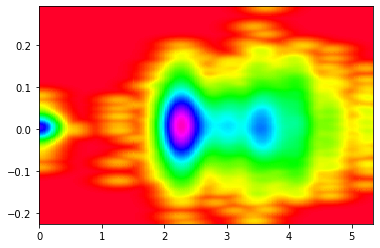

In [118]:
from scipy.stats import kde
import matplotlib.colors as colors

nbins = 200
x = df_1['Ap'].values
y = df_1['Vx'].values

k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = plt.get_cmap('gist_rainbow')

plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=cmap,
               norm=colors.PowerNorm(0.2))
plt.show()

# "good" pump

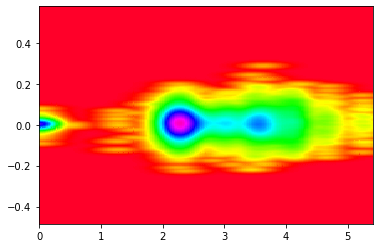

In [120]:
nbins = 200
xb = df_2['Ap'].values
yb = df_2['Vx'].values

kb = kde.gaussian_kde([xb,yb])
xib, yib = np.mgrid[xb.min():xb.max():nbins*1j, yb.min():yb.max():nbins*1j]
zib = k(np.vstack([xib.flatten(), yib.flatten()]))

cmap = plt.get_cmap('gist_rainbow')

plt.pcolormesh(xib, yib, zib.reshape(xib.shape), shading='auto', cmap=cmap,
            norm=colors.PowerNorm(0.2))
plt.show()

# "bad" pump